In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statistics import stdev
from scipy.stats import norm, logistic
from scipy.special import erf
import seaborn as sns; sns.set()
import csv

# MIEDŹ

## Ceny miedzi na przestrzeni 5 lat (Open) (cena za nie wiem jaką ilość)

In [16]:
copper_ = pd.read_csv('copper.csv', sep = ',', encoding = 'latin-1')
copper_

,Date,Close/Last,Volume,Open,High,Low
0,03/28/2023,4.0855,75067,4.0970,4.1130,4.0590
1,03/27/2023,4.0785,65558,4.0750,4.1020,4.0235
2,03/24/2023,4.0750,82229,4.1015,4.1485,4.0505
3,03/23/2023,4.1235,77824,4.0430,4.1265,4.0225
4,03/22/2023,4.0445,77119,4.0015,4.1075,3.9715
...,...,...,...,...,...,...
1254,04/05/2018,3.0745,107499,3.0285,3.0880,3.0135
1255,04/04/2018,3.0105,137745,3.0670,3.0695,2.9700
1256,04/03/2018,3.0635,109250,3.0445,3.0695,3.0385
1257,04/02/2018,3.0500,68976,3.0480,3.0725,3.0370


In [19]:
def equalize(df): #funkcja ta skaluje ceny miedzi do cen za tonę
    d = 2204.623
    col_names = [col for col in df.columns][1:]
    col_names.remove('Volume')
    for name in col_names:
        df[name] = df[name]*d
    return df

In [20]:
copper = equalize(copper_)
copper

,Date,Close/Last,Volume,Open,High,Low
0,03/28/2023,9006.987267,75067,9032.340431,9067.614399,8948.564757
1,03/27/2023,8991.554906,65558,8983.838725,9043.363546,8870.300641
2,03/24/2023,8983.838725,82229,9042.261234,9145.878516,8929.825462
3,03/23/2023,9090.762941,77824,8913.290789,9097.376809,8868.096018
4,03/22/2023,8916.597724,77119,8821.798935,9055.488972,8755.660244
...,...,...,...,...,...,...
1254,04/05/2018,6778.113414,107499,6676.700756,6807.875824,6643.631411
1255,04/04/2018,6637.017542,137745,6761.578741,6767.090299,6547.730310
1256,04/03/2018,6753.862560,109250,6711.974724,6767.090299,6698.746985
1257,04/02/2018,6724.100150,68976,6719.690904,6773.704168,6695.440051


In [21]:
def draw_stock(df, clr):
    fig, ax = plt.subplots(figsize = (15, 4))
    plt.xticks(rotation = 45)
    xloc = plt.MaxNLocator(9)
    ax.xaxis.set_major_locator(xloc)
    dates = df['Date'].values[::-1]
    prices = df['Open'].values[::-1]
    plt.plot(dates, prices, color = clr)
    plt.ylabel('USD')
    plt.show()

## Wykres cen miedzi

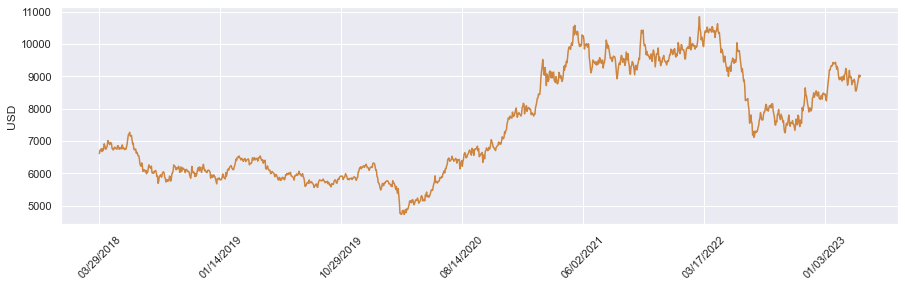

In [22]:
draw_stock(copper, 'peru')

## Histogram logarytmicznych przyrostów

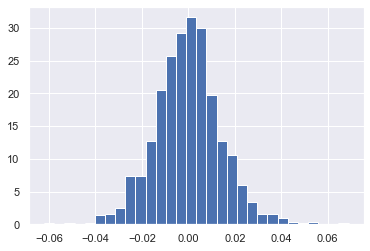

In [23]:
s = np.array(copper['Open'].values[1:])
s2 = np.array(copper['Open'].values[:-1])
r = np.log(s/s2)
plt.hist(r, bins = 30, density = True)
plt.show()

## Miary zmienności ryzyka

Z danych generujemy histogram i staramy się do niego dopasować rozkład. Na początku próbujemy z rozkładem normalnym, jednak ten nie jest najlepiej dopasowany. Udaje nam się znaleźć lepszą propozycję - rozkład logistyczny.

In [95]:
#Porównanie histogramu z wykresami funkcji gęstości
def norm_kde(x, mi, sigma):
    x = np.array(sorted(x))
    y = norm.pdf(x, mi, sigma) #rozkład normalny
    y2 = logistic.pdf(x, mi, math.sqrt(3)/math.pi*sigma) #rozkład logistyczny
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1) 
    plt.plot(x, y, color = 'blue', label = 'normal pdf')
    plt.plot(x, y2, color = 'green', label = 'logistic pdf')
    plt.hist(x, bins = 50, density = True, color = 'white', ec = 'black')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend()
    plt.show()

In [26]:
mu = np.mean(r)
s = stdev(r)
print('Średnia: ' + str(mu))
print('Odchylenie standardowe: ' + str(s))

Średnia: -0.0002474637775091431
Odchylenie standardowe: 0.014277995279475236


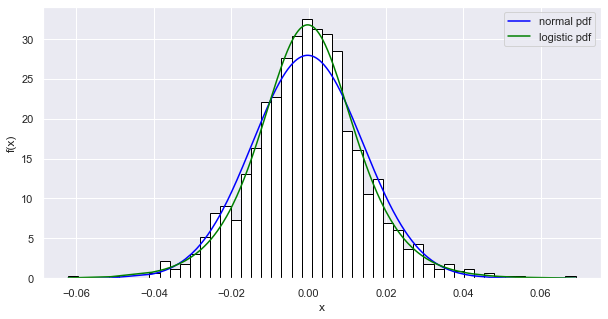

In [27]:
norm_kde(r, mu, s)

## Porównanie kwantyli (parametryczne i nieparametryczne) 95%, 97.5% i 99%

In [29]:
def comp_quantile(x, p1, p2, p3): #p ma być z zakresu [0, 1]
    mi = np.mean(x)
    sigma = stdev(x)
    p = [p1, p2, p3]
    real = np.quantile(x, p)
    nrm = norm.ppf(p, mi, sigma)
    lgstc = logistic.ppf(p, mi, math.sqrt(3)/math.pi*sigma)
    perc = [format(p, '.2%') for p in [p1, p2, p3]]
    dct = {'p' : perc, 'real' : real, 'normal' : nrm, 'logistic' : lgstc}
    df = pd.DataFrame(dct)
    return df

In [30]:
comp_quantile(r, .95, .975, .99)

,p,real,normal,logistic
0,95.00%,0.023474,0.023238,0.022931
1,97.50%,0.028719,0.027737,0.028592
2,99.00%,0.037611,0.032968,0.035925


## Wartości dystrybuanty

In [25]:
#Porównanie dystrybuant teoretycznych z dystrybuantą empiryczną
def cdf(x, mi, sigma):
    x = np.array(sorted(x))
    y = norm.cdf(x, mi, sigma)
    y2 = logistic.cdf(x, mi, math.sqrt(3)/math.pi*sigma)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(x, y, color = 'red', label = 'CDF', linestyle = 'dashdot')
    plt.plot(x, y2, color = 'blue', label = 'Logistic cdf', linestyle = 'dashdot')
    sns.ecdfplot(data = x, color = 'black', label = 'ECDF', alpha = 0.4)
    plt.xlabel('x')
    plt.ylabel('F(x)')
    plt.legend()
    plt.show()

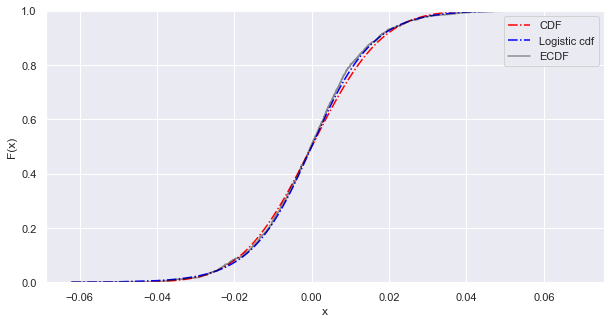

In [28]:
cdf(r, 0, s)

Sprawdzimy wartości dystrybuant dla $x \in \{-0.05, -0.03, -0.01, 0, 0.01, 0.03, 0.05\}$

In [33]:
def comp_dist(x, x0 = [-0.05, -0.03, -0.01, 0, 0.01, 0.03, 0.05]):
    x = sorted(x)
    mi = np.mean(x)
    sigma = stdev(x)
#     real = [np.linspace(0, 1, len(x))]
    nrm = norm.cdf(x0, mi, sigma)
    lgstc = logistic.cdf(x0, mi, sigma)
    dct = {'x0' : x0, 'normal' : nrm, 'logistic' : lgstc}
    df = pd.DataFrame(dct)
    return df

In [34]:
comp_dist(r)

,x0,normal,logistic
0,-0.05,0.000246,0.029755
1,-0.03,0.018589,0.110681
2,-0.01,0.247289,0.335582
3,0.00,0.506914,0.504333
4,0.01,0.763532,0.672103
5,0.03,0.982932,0.892685
6,0.05,0.999784,0.971230


# ALUMINIUM

## Ceny aluminium (Open) (w USD za tonę)

In [82]:
aluminium = pd.read_csv('aluminium.csv', sep = ',', encoding = 'latin-1')
aluminium

,Date,Close/Last,Volume,Open,High,Low
0,04/12/2023,2328.50,1205.0,2311.00,2335.0,2293.50
1,04/11/2023,2306.75,1979.0,2333.75,2335.5,2302.50
2,04/10/2023,2348.00,2215.0,2348.00,2348.0,2348.00
3,04/06/2023,2338.25,1373.0,2355.00,2359.5,2329.25
4,04/05/2023,2370.00,NaN,2370.00,2370.0,2370.00
...,...,...,...,...,...,...
1254,04/19/2018,2300.00,NaN,2300.00,2300.0,2300.00
1255,04/18/2018,2300.00,NaN,2300.00,2300.0,2300.00
1256,04/17/2018,2300.00,NaN,2300.00,2300.0,2300.00
1257,04/16/2018,2300.00,NaN,2300.00,2300.0,2300.00


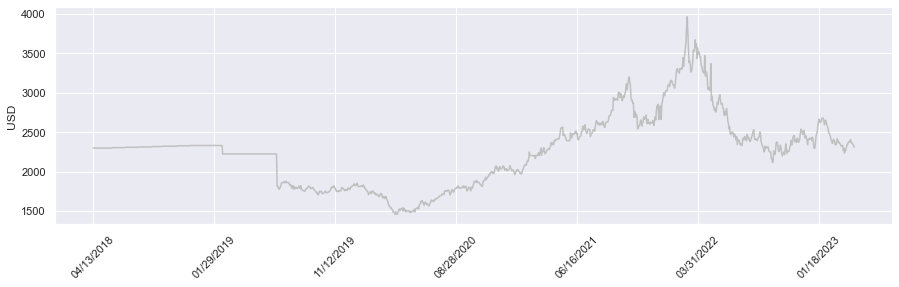

In [83]:
draw_stock(aluminium, 'silver')

In [84]:
idx = aluminium.index[aluminium['Date'] == '07/01/2019'].tolist()[0]
idx

952

In [87]:
aluminium2 = aluminium.drop(aluminium.index[idx:1259])


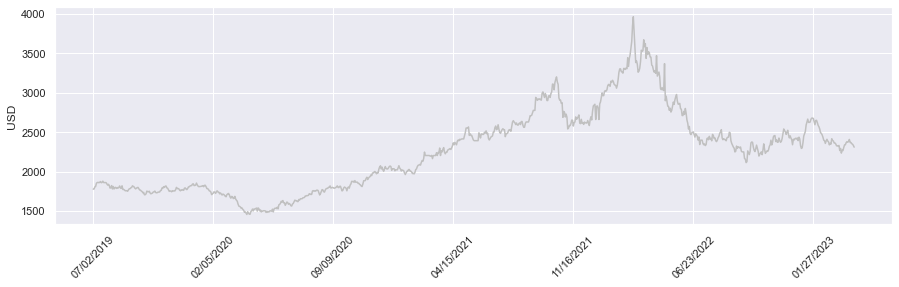

In [88]:
draw_stock(aluminium2, 'silver')

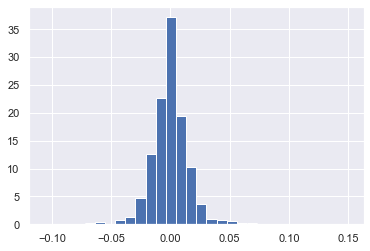

In [90]:
#logarytmiczne stopy zwrotu
s_ = np.array(aluminium2['Open'].values[1:])
s2_ = np.array(aluminium2['Open'].values[:-1])
r2 = np.log(s_/s2_)
plt.hist(r2, bins = 30, density = True)
plt.show()

In [91]:
mu2 = np.mean(r2)
s2 = stdev(r2)
print('Średnia: ' + str(mu2))
print('Odchylenie standardowe: ' + str(s2))

Średnia: -0.0002754048568726295
Odchylenie standardowe: 0.016525948225364212


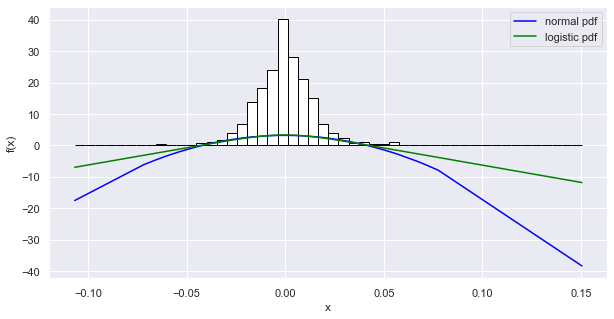

In [94]:
norm_kde(r2, mu2, s2)